In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
data1 = pd.read_csv('out/experiment.csv')
print(data1.shape)
data1.head()

(7200, 10)


,game_id,treatment,cohort_id,round,player1_id,player2_id,player1_choice,player2_choice,player1_payout,player2_payout
0,1,0.6,1,1,137,276,R,B,0,42
1,2,0.6,1,1,261,176,B,B,12,12
2,3,0.6,1,1,202,209,R,R,45,45
3,4,0.6,1,1,111,254,B,B,12,12
4,5,0.6,1,2,254,276,R,B,0,42


In [3]:
data2 = pd.read_csv('out2/experiment.csv')
print(data2.shape)
data2.head()

(7200, 10)


,game_id,treatment,cohort_id,round,player1_id,player2_id,player1_choice,player2_choice,player1_payout,player2_payout
0,1,0.6,1,1,137,276,R,B,0,42
1,2,0.6,1,1,261,176,R,R,45,45
2,3,0.6,1,1,202,209,R,R,45,45
3,4,0.6,1,1,111,254,R,R,45,45
4,5,0.6,1,2,254,276,R,B,0,42


In [4]:
def plot(data):
	treatments = data['treatment'].unique()
	num_treatments = len(treatments)

	averages = pd.DataFrame(index=range(1, 76), columns=treatments)
	stds = pd.DataFrame(index=range(1, 76), columns=treatments)

	for treatment in treatments:
		round_averages = []
		round_stds = []
		for round in range(1, 76):
			round_df = data.loc[(data['treatment'] == treatment) & (data['round'] == round), ['player1_payout', 'player2_payout']].reset_index(drop=True)
			round_averages.append(((round_df['player1_payout'] + round_df['player2_payout']) / 2).mean())
			round_stds.append(((round_df['player1_payout'] + round_df['player2_payout']) / 2).std())
		averages[treatment] = round_averages
		stds[treatment] = round_stds

	sns.set_theme(style="whitegrid")


	n_cols = 3
	n_rows = math.ceil(num_treatments / n_cols)

	fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
	axs = axs.flatten()

	for i, treatment in enumerate(treatments):
		mean_vals = averages[treatment]
		std_vals = stds[treatment]
		sns.lineplot(x=mean_vals.index, y=mean_vals, ax=axs[i])
		axs[i].fill_between(mean_vals.index, mean_vals - std_vals, mean_vals + std_vals, color='b', alpha=0.2)
		axs[i].set_title(treatment)
		axs[i].set_xlabel('Round number')
		axs[i].set_ylabel('Average Payout')

	for j in range(len(treatments), len(axs)):
		fig.delaxes(axs[j])

	fig.suptitle('Average payouts with standard deviation', fontsize=16)
	plt.tight_layout(rect=[0, 0, 1, 0.96])
	#plt.savefig(f'comparison_plot.pdf')
	plt.show()


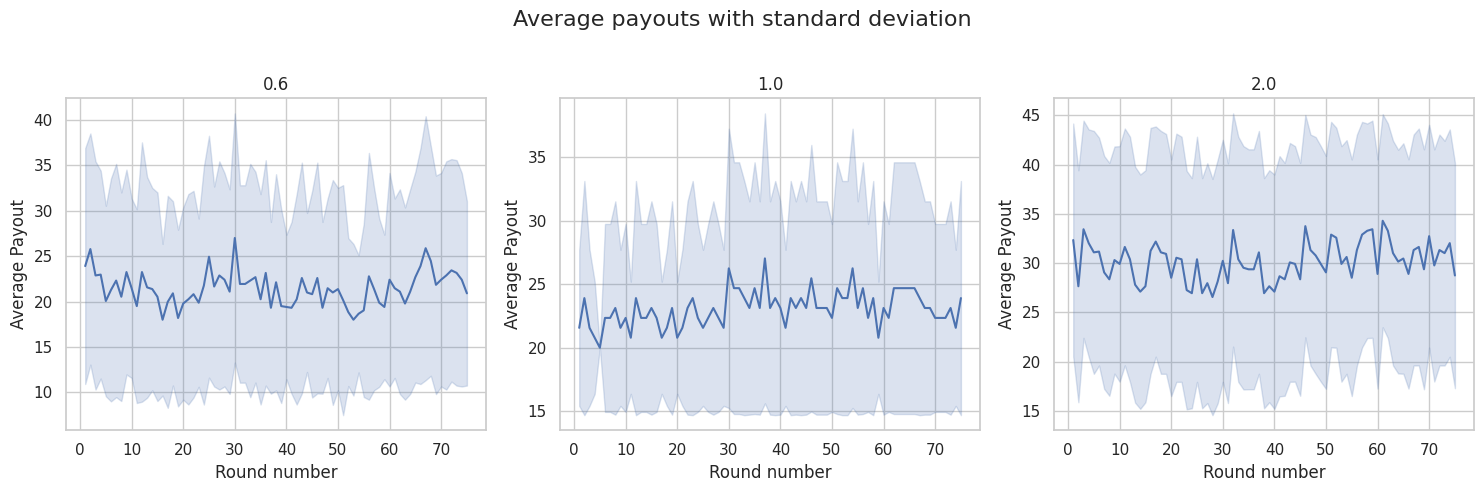

In [5]:
plot(data1)

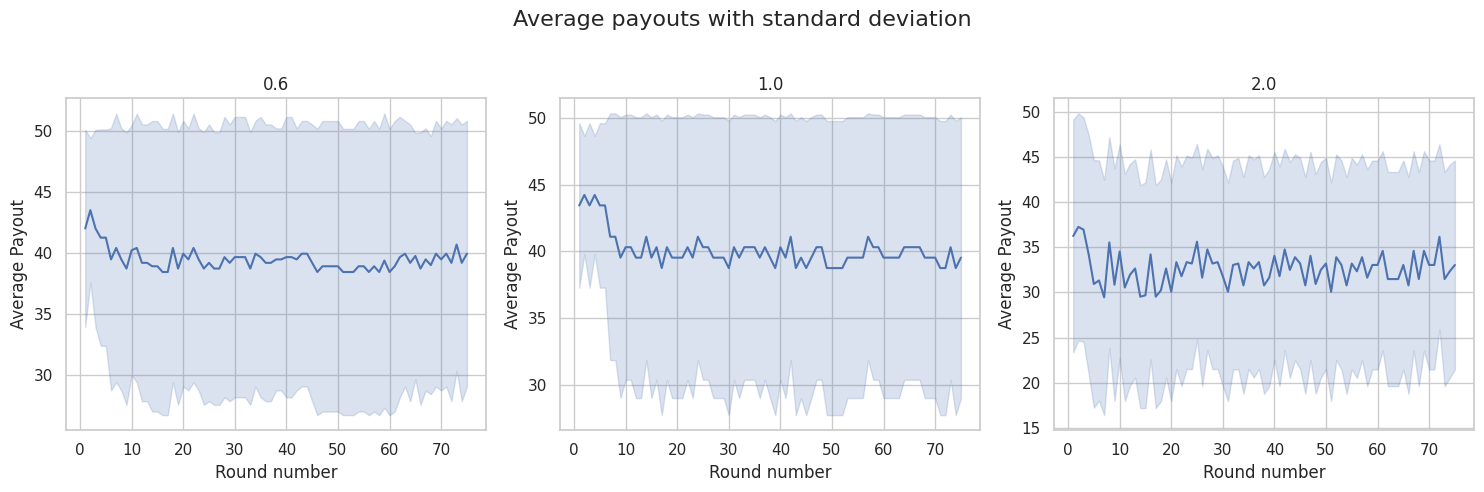

In [6]:
plot(data2)